In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from jupyterthemes import jtplot

#something for converting datetime for x axis
from pandas.plotting import register_matplotlib_converters
import matplotlib.dates as mdates
register_matplotlib_converters()
import math
import seaborn as sns
#jtplot.style()
#jtplot.reset()

In [2]:
# PLOT COLORS
cconfirmed = '#d10f0f'
cdeaths="#333232"
crecovered = "#0c91f0"

In [3]:
sns.set()
# sns.axes_style()

In [4]:
sns.set(style = {'axes.edgecolor': 'black',
                 'grid.color': 'white',
                 'axes.facecolor': '#f5f1df',
                 'xtick.bottom': True,
                'ytick.left': True})

In [5]:
### lists and dicts to help clear dataframes
#list of columns i want to keep
const_cols = ["Province/State", "Country", "Country/Region", "Date last updated", "Last Update", "Confirmed", "Recovered", "Deaths"]
#dict of column names to change
column_names = {"Country": "Country/Region", "Date last updated": "Last Update"}
#dict of columns and values to put in NaNs
fillna_values = {'Province/State': "", "Country/Region": "", "Confirmed": 0, "Recovered": 0, "Deaths":0}

In [6]:
def read_time_series_csv(url):
    
    df_ts = pd.read_csv(url)
    
    df_ts = df_ts.dropna(axis=0, how='all')
    df_ts = df_ts.dropna(axis=1, how='all')

    df_text = df_ts[df_ts.columns[0:2]]
    df_text = df_text.fillna(value = '')
    
    df_val = df_ts[df_ts.columns[2:len(df_ts.columns)]]
    df_val = df_val.fillna(value = 0)
    
    df_ts = pd.concat([df_text,df_val],axis=1)

    return df_ts

In [7]:
def save_one_file(df_confirmed, df_deaths, df_recovered, file_name):
    with pd.ExcelWriter(file_name, engine='xlsxwriter') as writer:
        df_confirmed.to_excel(writer, sheet_name='Confirmed')
        df_deaths.to_excel(writer, sheet_name='Deaths')
        df_recovered.to_excel(writer, sheet_name='Recovered')

In [8]:
url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
url_deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
url_recovered = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"

In [9]:
df_confirmed = read_time_series_csv(url_confirmed)
df_deaths = read_time_series_csv(url_deaths)
df_recovered = read_time_series_csv(url_recovered)

In [10]:
save_one_file(df_confirmed, df_deaths, df_recovered, "TimeSeries.xlsx")

In [11]:
df_confirmed_gb = df_confirmed.groupby('Country/Region').sum()
df_deaths_gb = df_deaths.groupby('Country/Region').sum()
df_recovered_gb = df_recovered.groupby('Country/Region').sum()

df_confirmed_gb = df_confirmed_gb.reset_index()
df_deaths_gb = df_deaths_gb.reset_index()
df_recovered_gb = df_recovered_gb.reset_index()

save_one_file(df_confirmed_gb, df_deaths_gb, df_recovered_gb, "CasesByCountry.xlsx")

In [12]:
print("Shape of df_confirmed: {}".format(df_confirmed_gb.shape))
print("Shape of df_deaths: {}".format(df_deaths_gb.shape))
print("Shape of df_recovered: {}".format(df_recovered_gb.shape))

#printing whole df
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(df_confirmed)

Shape of df_confirmed: (177, 70)
Shape of df_deaths: (177, 70)
Shape of df_recovered: (177, 70)


In [13]:
confirmed_countries = []
for col in df_confirmed_gb.iloc[:,3:].columns:
    s = df_confirmed_gb.apply(lambda x: True if x[col] > 0 else False , axis=1)
    numOfRows = len(s[s == True].index)
    confirmed_countries.append(numOfRows)
#     print('Number of countries with at least 1 confirmed case on {}: {} '.format(col,numOfRows))
print(confirmed_countries)

[6, 8, 9, 11, 13, 16, 16, 18, 20, 24, 25, 25, 25, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 29, 29, 31, 31, 31, 36, 40, 47, 51, 57, 61, 66, 73, 77, 81, 85, 94, 95, 100, 103, 106, 112, 114, 120, 134, 138, 143, 146, 150, 154, 161, 163, 168, 169, 171, 174, 175, 176, 177]


In [14]:
deaths_countries = []
for col in df_deaths_gb.iloc[:,3:].columns:
    s = df_deaths_gb.apply(lambda x: True if x[col] > 0 else False , axis=1)
    numOfRows = len(s[s == True].index)
    deaths_countries.append(numOfRows)
#     print('Number of countries with at least 1 confirmed case on {}: {} '.format(col,numOfRows))
print(deaths_countries)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 4, 5, 5, 5, 6, 8, 9, 9, 9, 9, 9, 9, 9, 9, 10, 12, 12, 14, 15, 17, 18, 18, 20, 22, 24, 33, 37, 40, 45, 47, 48, 54, 59, 66, 70, 79, 86, 90, 92, 96, 102, 108, 111]


In [16]:
def get_dates():
    df_confirmed_gb_dates = df_confirmed_gb.iloc[:,3:]
    df_confirmed_gb_dates = df_confirmed_gb_dates.transpose()
    
    dates = df_confirmed_gb_dates.index.values
    dates = pd.to_datetime(dates, infer_datetime_format=True)
    
    return dates

dates = get_dates()
print(dates)

DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02',
               '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06',
               '2020-02-07', '2020-02-08', '2020-02-09', '2020-02-10',
               '2020-02-11', '2020-02-12', '2020-02-13', '2020-02-14',
               '2020-02-15', '2020-02-16', '2020-02-17', '2020-02-18',
               '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22',
               '2020-02-23', '2020-02-24', '2020-02-25', '2020-02-26',
               '2020-02-27', '2020-02-28', '2020-02-29', '2020-03-01',
               '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05',
               '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09',
               '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13',
               '2020-03-14', '2020-03-15', '2020-03-16', '2020-03-17',
      

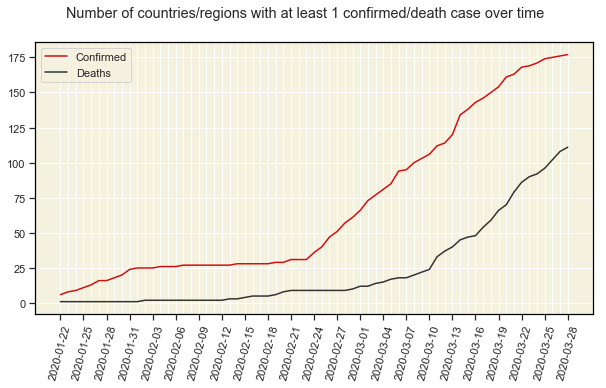

In [17]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.plot(dates,confirmed_countries, color = cconfirmed)
ax.plot(dates,deaths_countries, color = cdeaths)
plt.xticks(rotation=75)
ax.legend(['Confirmed', 'Deaths'])
fig.suptitle('Number of countries/regions with at least 1 confirmed/death case over time')
ax.set_xticks(dates)

every_nth = 3
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

for n, line in enumerate(ax.xaxis.get_ticklines()):
    if n % every_nth != 0:
        line.set_visible(False)

plt.savefig("img/num_of_countries.png",bbox_inches='tight')

In [27]:
#default index_end will be last  
def plot_one_country(country, index_start = 0, index_end = len(dates), every_nth = 3):
    
    country_confirmed = df_confirmed_gb[df_confirmed_gb['Country/Region']==country].iloc[:,3+index_start:3+index_end]
    country_deaths = df_deaths_gb[df_deaths_gb['Country/Region']==country].iloc[:,3+index_start:3+index_end]
    country_recovered = df_recovered_gb[df_recovered_gb['Country/Region']==country].iloc[:,3+index_start:3+index_end]
    
    country_confirmed = country_confirmed.transpose()
    country_deaths = country_deaths.transpose()
    country_recovered = country_recovered.transpose()
    
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)
    ax.plot(dates[index_start:index_end], country_confirmed, color = cconfirmed)
    ax.plot(dates[index_start:index_end], country_deaths, color = cdeaths)
    ax.plot(dates[index_start:index_end], country_recovered, color = crecovered)
    plt.xticks(rotation=75)
    ax.legend(['Confirmed', 'Deaths', 'Recovered'])
    fig.suptitle(country)
    ax.set_xticks(dates[index_start:index_end])

    #every_nth = 3
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

    for n, line in enumerate(ax.xaxis.get_ticklines()):
        if n % every_nth != 0:
            line.set_visible(False)

    plt.savefig("img/{}.png".format(country),bbox_inches='tight')

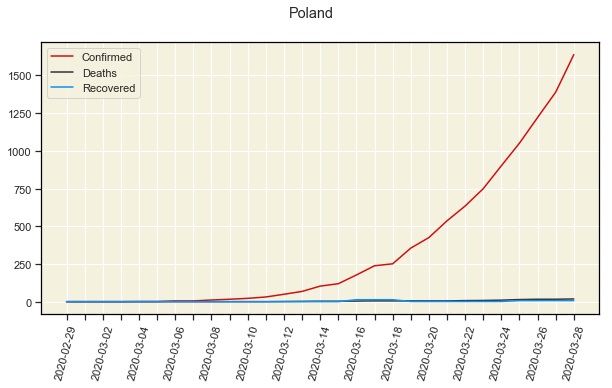

In [28]:
plot_one_country("Poland", every_nth = 2, index_start = 38)

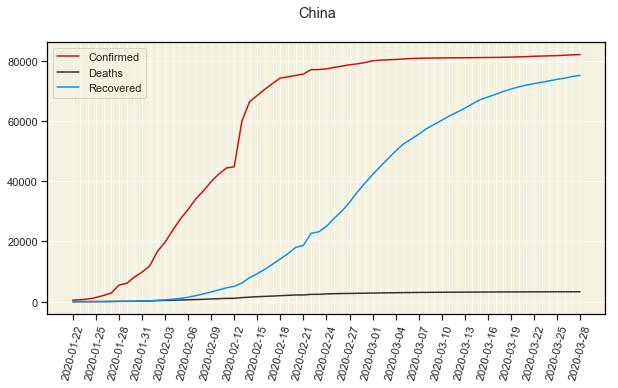

In [29]:
plot_one_country("China")

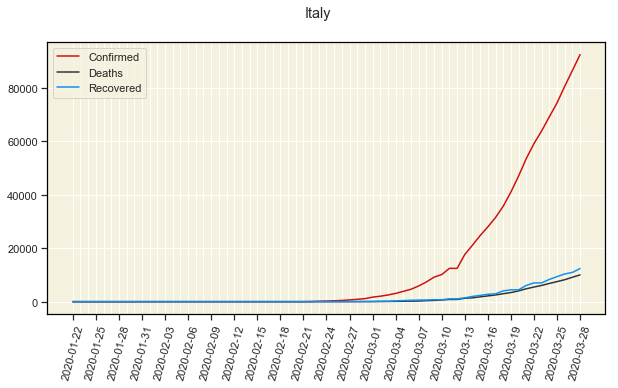

In [30]:
plot_one_country("Italy")

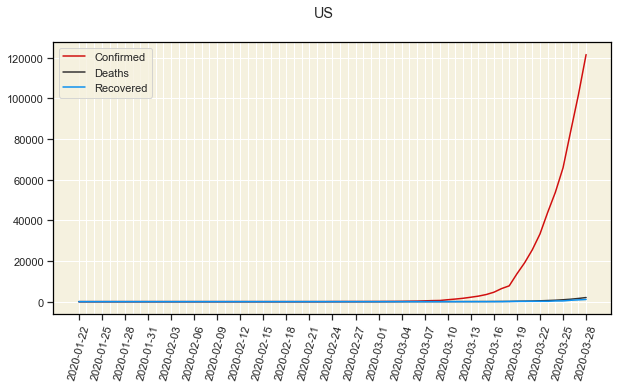

In [32]:
plot_one_country("US")

In [33]:
# countries = df_confirmed['Country/Region'].unique()
countries = df_confirmed_gb['Country/Region'].unique()
print("Number of countries with at least 1 confirmed case: {}".format(len(countries)))
#print(countries)

Number of countries with at least 1 confirmed case: 177


In [34]:
#list of number of confirmed cases from last column
    
confirmed_country = df_confirmed_gb.iloc[:,-1].tolist()

cc_sort = confirmed_country.copy()
cc_sort.sort()
print("Sorted number of confirmed cases: {}".format(cc_sort))

Sorted number of confirmed cases: [1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 10, 10, 11, 12, 12, 14, 14, 16, 16, 18, 19, 25, 26, 26, 28, 30, 30, 34, 38, 42, 48, 56, 56, 58, 60, 65, 74, 74, 84, 89, 90, 91, 91, 94, 95, 98, 99, 101, 102, 104, 110, 113, 119, 119, 120, 130, 141, 149, 152, 174, 179, 182, 197, 207, 224, 228, 231, 235, 241, 246, 258, 274, 278, 283, 292, 295, 305, 308, 331, 343, 356, 394, 402, 407, 412, 451, 454, 468, 476, 506, 576, 590, 608, 645, 657, 659, 671, 684, 690, 712, 717, 719, 786, 802, 963, 987, 1061, 1075, 1155, 1167, 1187, 1203, 1245, 1264, 1452, 1495, 1638, 1693, 1823, 1831, 1909, 2320, 2366, 2415, 2631, 3447, 3619, 3640, 3904, 4015, 5170, 5576, 7402, 8271, 9134, 9478, 9819, 14076, 17312, 35408, 38105, 57695, 73235, 81999, 92472, 121478]


In [35]:
#print(dates)

In [36]:
# # I am not using it anymore
# def multi_plot_limits(png_name):
    
#     dictionary = {"Country": countries ,"Confirmed": confirmed_country}
#     countries_last_date = pd.DataFrame(dictionary)
#     in_limits = countries_last_date.apply(lambda x: False if x['Confirmed'] < limit_low else (False if x['Confirmed'] > limit_high else True), axis=1)
#     # print(in_limits)
#     how_many = len(in_limits[in_limits == True].index)
#     print('Number of countries with number of confirmed cases between {} and {}: {}'.format(limit_low,limit_high, how_many))
    
    
#     indexTrue = in_limits[ in_limits == False ].index.tolist()
#     indexFalse = in_limits[ in_limits == True ].index.tolist()
#     # #copying to not change original df
#     countries_in_limits = countries_last_date.copy()
#     countries_in_limits.drop(indexTrue, inplace=True, axis=0)
    
    
#     #define how many rows on how many countries in list without china
#     plots_in_col = math.ceil((how_many)/plots_in_row)

#     fig, axs = plt.subplots(plots_in_col, plots_in_row, figsize=(15, plots_in_col*4), sharey=True, sharex=True)
#     fig.autofmt_xdate(rotation = 65)  
#     axs0 = axs.shape[0]
#     axs1 = axs.shape[1]

#     i = 0
#     j = 0
    
#     date_fmt = mdates.DateFormatter('%Y-%m-%d')
    
#     for country in countries_in_limits["Country"]:
#         axs[i][j].plot(dates, df_confirmed[df_confirmed['Country/Region']==country].iloc[:,4:].sum(axis = 0), color = cconfirmed)
#         axs[i][j].plot(dates, df_deaths[df_deaths['Country/Region']==country].iloc[:,4:].sum(axis = 0), color = cdeaths)
#         axs[i][j].plot(dates, df_recovered[df_recovered['Country/Region']==country].iloc[:,4:].sum(axis = 0), color = crecovered)
#         axs[i][j].set_title(country)
#         #axs[i][j].set_xticklabels(rotation=75)

#         every_nth = 5
#         dates.freq = 'd'
#         list_dates = []
#         for d in range(len(dates)):
#             if d % every_nth == 0:
#                 list_dates.append(dates[d])
        
#         axs[i][j].set_xticks(list_dates)
#         axs[i][j].xaxis.set_major_formatter(date_fmt)
# #         for n, label in enumerate(axs[i][j].xaxis.get_ticklabels()):
# #             if n % every_nth != 0:
# #                 label.set_visible(False)

# #         for n, line in enumerate(axs[i][j].xaxis.get_ticklines()):
# #             if n % every_nth != 0:
# #                 line.set_visible(False)
    
#         i = i + 1
#         if i==plots_in_col:
#             i = 0
#             j = j + 1
#             if j==plots_in_row:
#                 j = 0
              
#     fig.suptitle('Countries with number of confirmed cases between {} and {}'.format(limit_low, limit_high))
#     fig.legend(['Confirmed', 'Deaths', 'Recovered'],loc='upper left', bbox_to_anchor=(0.11, 0., 0., 1.),bbox_transform=plt.gcf().transFigure)
#     plt.savefig(png_name,bbox_inches='tight')

In [37]:
df_nlargest = df_confirmed_gb.nlargest(11,df_confirmed_gb.columns[-1])
df_nsmallest = df_nlargest.nsmallest(9, df_nlargest.columns[-1])
df_multiplot_confirmed = df_nsmallest.nlargest(9, df_nsmallest.columns[-1])
df_multiplot_deaths = df_deaths_gb[df_deaths_gb['Country/Region'].isin(df_multiplot_confirmed['Country/Region'].tolist())]
df_multiplot_recovered = df_recovered_gb[df_recovered_gb['Country/Region'].isin(df_multiplot_confirmed['Country/Region'].tolist())]

In [40]:
def multi_plot(png_name):
    
    plots_in_row = 3
    plots_in_col = 3

    fig, axs = plt.subplots(plots_in_col, plots_in_row, figsize=(15, plots_in_col*4), sharey=True, sharex=True)
    fig.autofmt_xdate(rotation = 65)  
    axs0 = axs.shape[0]
    axs1 = axs.shape[1]

    i = 0
    j = 0
    
    date_fmt = mdates.DateFormatter('%Y-%m-%d')
    
    
    for country in df_multiplot_confirmed['Country/Region']:
        axs[i][j].plot(dates, df_multiplot_confirmed[df_multiplot_confirmed['Country/Region']==country].iloc[0,3:].tolist(), color = cconfirmed)
        axs[i][j].plot(dates, df_multiplot_deaths[df_multiplot_deaths['Country/Region']==country].iloc[0,3:].tolist(), color = cdeaths)
        axs[i][j].plot(dates, df_multiplot_recovered[df_multiplot_recovered['Country/Region']==country].iloc[0,3:].tolist(), color = crecovered)
        axs[i][j].set_title(country, size = 'large')
        #axs[i][j].set_xticklabels(rotation=75)

        every_nth = 5
        dates.freq = 'd'
        list_dates = []
        for d in range(len(dates)):
            if d % every_nth == 0:
                list_dates.append(dates[d])
        
        axs[i][j].set_xticks(list_dates)
        axs[i][j].xaxis.set_major_formatter(date_fmt)
#         for n, label in enumerate(axs[i][j].xaxis.get_ticklabels()):
#             if n % every_nth != 0:
#                 label.set_visible(False)

#         for n, line in enumerate(axs[i][j].xaxis.get_ticklines()):
#             if n % every_nth != 0:
#                 line.set_visible(False)
    
        i = i + 1
        if i==plots_in_col:
            i = 0
            j = j + 1
            if j==plots_in_row:
                j = 0
              
    fig.suptitle('9 countries with most confirmed cases (without US nad Italy)',size='xx-large')
    fig.legend(['Confirmed', 'Deaths', 'Recovered'],loc='upper left', bbox_to_anchor=(0.11, 0., 0., 1.),bbox_transform=plt.gcf().transFigure)
    plt.savefig(png_name,bbox_inches='tight')

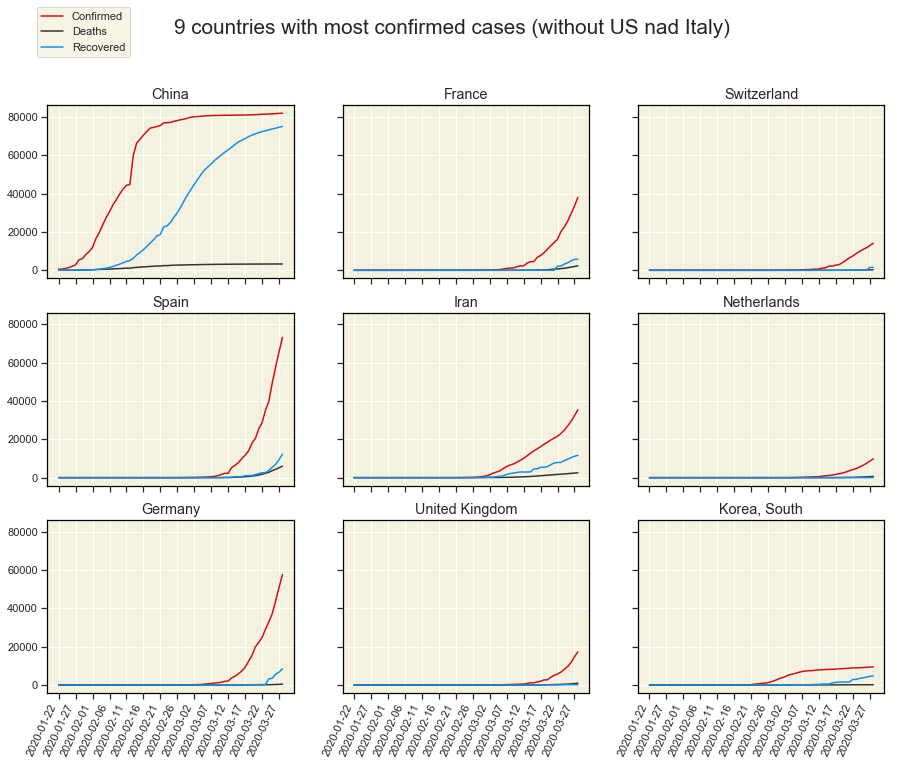

In [41]:
multi_plot('img/most_confirmed_cases.png')

In [42]:
df_confirmed_gb.iloc[:,4:].max().max()

121478

In [43]:
# limit_high = 20000
# limit_low = 5000

In [44]:
# plots_in_row = 3
# multi_plot("img/between_1500_15000.png")

In [45]:
# limit_high = df_confirmed_gb.iloc[:,4:].max().max()
# limit_low = 5000

In [46]:
# plots_in_row = 3
# multi_plot("img/between_limits.png")

In [47]:
def make_df_colCountry_rowValues(df, countries_ts):
    #new df - columns will be countries, index is date
    df_colCountry_rowConfirmed = pd.DataFrame()
    #print(df_colCountry_rowConfirmed)
    for i, country in enumerate(countries_ts,0):
        column = df[df['Country/Region']==country].iloc[:,4:].sum(axis=0)
        df_colCountry_rowConfirmed.insert(i, country, column)
    #print(df_colCountry_rowConfirmed.tail(3))
    return df_colCountry_rowConfirmed

In [48]:
# df_colCountry_rowConfirmed = make_df_colCountry_rowValues(df_confirmed, countries)
# df_colCountry_rowDeaths = make_df_colCountry_rowValues(df_deaths, countries)
# df_colCountry_rowRecovered = make_df_colCountry_rowValues(df_recovered, countries)

In [49]:
#przyrosty względne
# rel_change_confirmed = df_colCountry_rowConfirmed.pct_change()
rel_change_confirmed = df_confirmed_gb.iloc[:,3:].pct_change(axis= 1)
#print(rel_change_confirmed)

In [50]:
abs_change_confirmed = df_confirmed_gb.iloc[:,3:].diff(axis = 1)
abs_change_deaths = df_deaths_gb.iloc[:,3:].diff(axis = 1)
abs_change_recovered = df_recovered_gb.iloc[:,3:].diff(axis = 1)
print(abs_change_confirmed.head(3))

   1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  \
0      NaN      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1      NaN      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2      NaN      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

   1/30/20  1/31/20  ...  3/19/20  3/20/20  3/21/20  3/22/20  3/23/20  \
0      0.0      0.0  ...      0.0      2.0      0.0     16.0      0.0   
1      0.0      0.0  ...      5.0      6.0      6.0     13.0     15.0   
2      0.0      0.0  ...     13.0      3.0     49.0     62.0     29.0   

   3/24/20  3/25/20  3/26/20  3/27/20  3/28/20  
0     34.0     10.0     10.0     16.0      0.0  
1     19.0     23.0     28.0     12.0     11.0  
2     34.0     38.0     65.0     42.0     45.0  

[3 rows x 67 columns]


In [51]:
#plt.plot(df_colCountry_rowConfirmed["Mainland China"].diff())

In [52]:
daily_abs_change_confirmed_all = abs_change_confirmed.sum(axis=0)
daily_abs_change_deaths_all = abs_change_deaths.sum(axis=0)
daily_abs_change_recovered_all = abs_change_recovered.sum(axis=0)

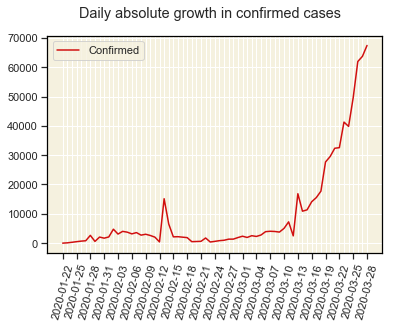

In [53]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.plot(dates, daily_abs_change_confirmed_all, color = cconfirmed)
plt.xticks(rotation=75)
ax.legend(['Confirmed'])
fig.suptitle('Daily absolute growth in confirmed cases')
ax.set_xticks(dates)

every_nth = 3
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

for n, line in enumerate(ax.xaxis.get_ticklines()):
    if n % every_nth != 0:
        line.set_visible(False)

plt.savefig("img/abs_growth_confirmed.png",bbox_inches='tight')

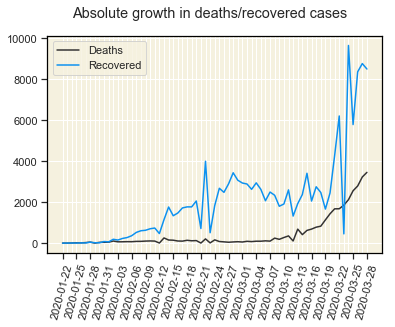

In [54]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.plot(dates, daily_abs_change_deaths_all, color = cdeaths)
ax.plot(dates, daily_abs_change_recovered_all, color = crecovered)
plt.xticks(rotation=75)
ax.legend(['Deaths', 'Recovered'])
fig.suptitle('Absolute growth in deaths/recovered cases')
ax.set_xticks(dates)

every_nth = 3
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

for n, line in enumerate(ax.xaxis.get_ticklines()):
    if n % every_nth != 0:
        line.set_visible(False)

plt.savefig("img/abs_growth_deaths_recovered.png",bbox_inches='tight')